In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import networkx as nx
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# Generate synthetic data
def generate_data(num_samples=1000):
    x = np.linspace(-10, 10, num_samples)
    y = np.abs(x) + np.sin(x)
    return x, y
x_data, y_data = generate_data()
x_min, x_max = x_data.min(), x_data.max()
y_min, y_max = y_data.min(), y_data.max()
x_data = (x_data - x_min) / (x_max - x_min)
y_data = (y_data - y_min) / (y_max - y_min)
x_tensor = torch.tensor(x_data, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(y_data, dtype=torch.float32).unsqueeze(1)
dataset = TensorDataset(x_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [3]:
# Define SoftplusSquared Activation function
class SoftplusSquared(nn.Module):
    def __init__(self, beta=1):
        super(SoftplusSquared, self).__init__()
        self.beta = nn.Parameter(torch.tensor(float(beta)))  # Make beta a trainable parameter
    def forward(self, x):
        return (1 / (2 * self.beta ** 4)) * (torch.log10(torch.exp(self.beta ** 2 * x))) ** 2

# Define a Constrained Linear Model (positive weights)
class ConstrainedLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super(ConstrainedLinear, self).__init__()
        self.raw_weights = nn.Parameter(torch.randn(out_features, in_features)) # Make raw_weights trainable parameter
        self.alpha = nn.Parameter(torch.tensor(0.1)) # Make alpha a trainable parameter
    def forward(self, x):
        positive_weights = (1 / (self.alpha ** 2)) * torch.log10(torch.exp(self.alpha ** 2 * self.raw_weights))
        return F.linear(x, positive_weights)

In [4]:
# Define neural network model
class ICNN(nn.Module):
    def __init__(self, input_dim):
        super(ICNN, self).__init__()
        self.layer1 = nn.Linear(input_dim, 20)
        self.constrained_layer1 = ConstrainedLinear(20, 10)
        self.constrained_layer2 = ConstrainedLinear(10, 10)
        self.constrained_layer3 = ConstrainedLinear(10, 1)
        self.A = nn.Parameter(torch.randn(input_dim, input_dim))  # Trainable A
        self.shortcut_layer2 = nn.Linear(input_dim, 10, bias=False)
        self.shortcut_layer3 = nn.Linear(input_dim, 10, bias=False)
        self.activation = SoftplusSquared()
    def forward(self, x):
        x0 = x  # Original input (batch_size, input_dim)
        shortcut2 = self.shortcut_layer2(x)  
        shortcut3 = self.shortcut_layer3(x)  
        x = self.activation(self.layer1(x))  
        x = self.activation(self.constrained_layer1(x) + shortcut2) 
        x = self.activation(self.constrained_layer2(x) + shortcut3)
        # Quadratic term computation: f(x0) = x0^T A^T A x0
        quadratic_term = torch.matmul(x0, self.A.T)  # (batch_size, input_dim) @ (input_dim, input_dim) -> (batch_size, input_dim)
        quadratic_term = torch.matmul(quadratic_term, self.A)  # (batch_size, input_dim) @ (input_dim, input_dim) -> (batch_size, input_dim)
        quadratic_output = torch.sum(quadratic_term * x0, dim=1, keepdim=True)  # Scalar per sample, shape: (batch_size, 1)
        x = self.constrained_layer3(x) + quadratic_output  # Shape: (batch_size, 1)
        return x

In [5]:
# Instantiate the model, define loss and 
input_dim=1
model = ICNN(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Reduced learning rate for stability
epochs = 1000
for epoch in range(epochs):
    model.train()
    for batch_x, batch_y in dataloader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        # Clip gradients to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
# Evaluate the model
model.eval()
y_pred = model(x_tensor).detach().numpy()
# Unnormalize x_data, y_data, and y_pred for plotting
x_data = x_data * (x_max - x_min) + x_min
y_data = y_data * (y_max - y_min) + y_min
y_pred = y_pred * (y_max - y_min) + y_min

Epoch [100/1000], Loss: 0.0098
Epoch [200/1000], Loss: 0.0086
Epoch [300/1000], Loss: 0.0086
Epoch [400/1000], Loss: 0.0097
Epoch [500/1000], Loss: 0.0087
Epoch [600/1000], Loss: 0.0091
Epoch [700/1000], Loss: 0.0050
Epoch [800/1000], Loss: 0.0057
Epoch [900/1000], Loss: 0.0055
Epoch [1000/1000], Loss: 0.0055


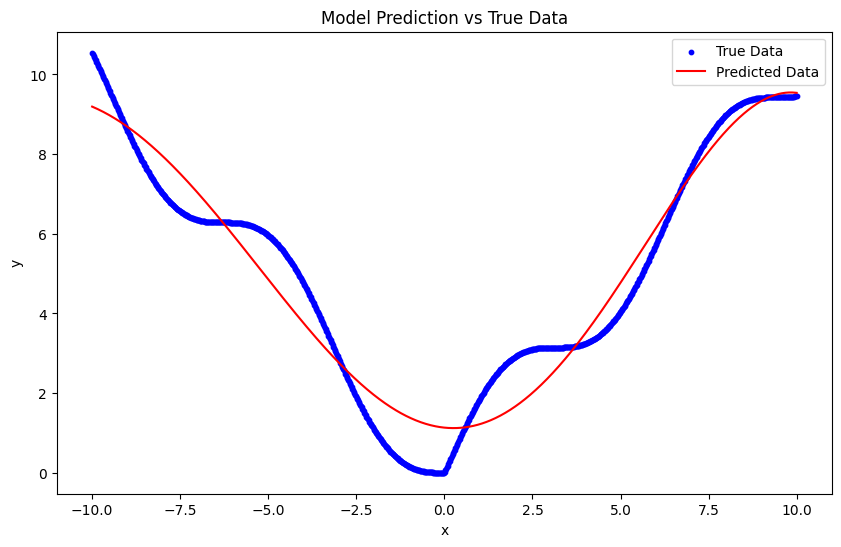

In [6]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(x_data, y_data, label='True Data', color='blue', s=10)
plt.plot(x_data, y_pred, label='Predicted Data', color='red')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Model Prediction vs True Data')
plt.show()

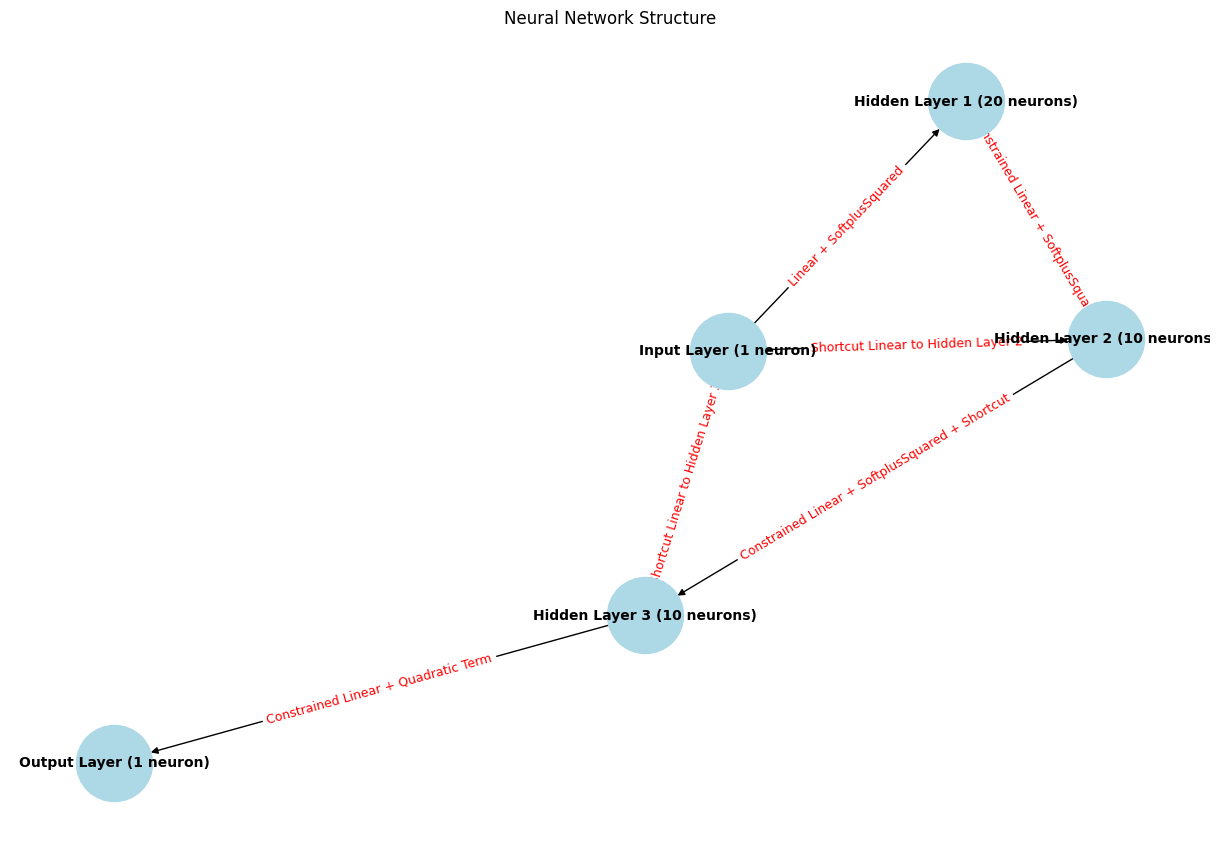

In [7]:
# Draw the neural network structure
G = nx.DiGraph()
# Adding nodes for each layer
G.add_node("Input Layer (1 neuron)")
G.add_node("Hidden Layer 1 (20 neurons)")
G.add_node("Hidden Layer 2 (10 neurons)")
G.add_node("Hidden Layer 3 (10 neurons)")
G.add_node("Output Layer (1 neuron)")
# Adding edges to represent connections
G.add_edge("Input Layer (1 neuron)", "Hidden Layer 1 (20 neurons)", label="Linear + SoftplusSquared")
G.add_edge("Input Layer (1 neuron)", "Hidden Layer 2 (10 neurons)", label="Shortcut Linear to Hidden Layer 2")
G.add_edge("Input Layer (1 neuron)", "Hidden Layer 3 (10 neurons)", label="Shortcut Linear to Hidden Layer 3")  # Add shortcut connection
G.add_edge("Hidden Layer 1 (20 neurons)", "Hidden Layer 2 (10 neurons)", label="Constrained Linear + SoftplusSquared")
G.add_edge("Hidden Layer 2 (10 neurons)", "Hidden Layer 3 (10 neurons)", label="Constrained Linear + SoftplusSquared + Shortcut")
G.add_edge("Hidden Layer 3 (10 neurons)", "Output Layer (1 neuron)", label="Constrained Linear + Quadratic Term")
# Draw the graph
pos = nx.spring_layout(G)
plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=10, font_weight='bold', arrows=True)
edges = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edges, font_size=9, font_color='red')
plt.title("Neural Network Structure")
plt.show()